In [3]:
"""Sandbox module."""
import matplotlib.pyplot as plt
import numpy as np
import warnings

from fda_funcs import (
    compute_moments,
    compute_principal_components,
    compute_fpc_scores,
    mode_of_variation
)
from misc import (
    cdf_from_density,
    norm_pdf,
    quantile_from_cdf,
    riemann_sum_arrays,
    trunc_norm_pdf,
)
from scipy.stats import norm, truncnorm
from scipy.interpolate import interp1d

%matplotlib inline

In [4]:
# Make the warning always appear
warnings.filterwarnings("always")

$\int_0^1 f(t)dt$  wird dann durch die Riemann Summe $1/m \sum_{j=1}^m f(s_j)$ ersetzt ($s_j$  - Gridpunkte, $m$ -  Anzahl der Gridpunkte).

# Functional Data Analysis

Ideas for simulation
- Uni- vs. Multivariate case
- Simulate different normal distributions
- Vary parameters of (generalized) Beta distribution, so principal components can be interpreted as varying parameters

$X(t) = \sum_{k=1}^n η_k φ_k(t)$


## Transformation Method Paper (Petersen & Müller 2016)

In [5]:
# 1. Generate synthetic functional data
n = 200
gridnum = 1000
truncation_point = 3
delta=1e-10

grid_densities = np.linspace(
    start=-truncation_point,
    stop=truncation_point,
    num=gridnum,
)
grid_quantiles = np.linspace(start=delta, stop=1-delta, num=gridnum)
range_support = grid_densities[-1] - grid_densities[0]

# Draw different sigmas
log_sigmas = np.random.default_rng(seed=28071995).uniform(-1.5, 1.5, n)
mus = np.zeros(n)
sigmas = np.exp(log_sigmas)

In [6]:
# Calculate discretized distributions, with different methods, to compare performance

# Calculate densities
a, b = (-truncation_point - mus) / sigmas, (truncation_point - mus) / sigmas
densities_discretized = norm_pdf(grid_densities[:,np.newaxis], mus, sigmas).transpose()
densities_discretized2 = truncnorm.pdf(
    x=grid_densities[:, np.newaxis],
    a=a,
    b=b,
    loc=mus,
    scale=sigmas,
).transpose()
densities_discretized3 = trunc_norm_pdf(
    grid_densities[:, np.newaxis],
    mus,
    sigmas,
    -truncation_point,
    truncation_point,
).transpose()

# Calculate distribution functions
cdfs_discretized = cdf_from_density(
    grid_densities,
    densities_discretized,
    axis=1,
)
cdfs_discretized2 = cdf_from_density(
    grid_densities,
    densities_discretized2,
    axis=1,
)
cdfs_discretized3 = cdf_from_density(
    grid_densities,
    densities_discretized3,
    axis=1,
)

# Calculate quantiles
quantiles_discretized = norm.ppf(grid_quantiles[:, np.newaxis], mus, sigmas).transpose()
quantiles_discretized2 = truncnorm.ppf(
    q=grid_quantiles[:, np.newaxis],
    a=a,
    b=b,
    loc=mus,
    scale=sigmas,
).transpose()
quantiles_discretized3 = quantile_from_cdf(
    grid_densities[:, np.newaxis].transpose(),
    cdfs_discretized3,
    grid_quantiles,
)

# Calculate quantile densities
quantile_densities_discretized = np.reciprocal(
    norm_pdf(quantiles_discretized.transpose(), mus, sigmas),
).transpose()
quantile_densities_discretized2 = np.reciprocal(
    truncnorm.pdf(quantiles_discretized2.transpose(), a=a, b=b, loc=mus, scale=sigmas),
).transpose()
quantile_densities_discretized3 = np.reciprocal(
    trunc_norm_pdf(
        quantiles_discretized3.transpose(),
        mus,
        sigmas,
        -truncation_point,
        truncation_point,
    ),
).transpose()

# Normalize quantile densities
quantile_densities_discretized = (
    quantile_densities_discretized
    * range_support
    / riemann_sum_arrays(grid_quantiles, quantile_densities_discretized, axis = 1)[:, np.newaxis]
)

quantile_densities_discretized2 = (
    quantile_densities_discretized2
    * range_support
    / riemann_sum_arrays(grid_quantiles, quantile_densities_discretized2, axis = 1)[:, np.newaxis]
)

quantile_densities_discretized3 = (
    quantile_densities_discretized3
    * range_support
    / riemann_sum_arrays(grid_quantiles, quantile_densities_discretized3, axis = 1)[:, np.newaxis]
)

c:\Coding\thesis_frechet_fda\src\frechet_fda\misc.py:140: UserWarning: Not all provided densities integrate to 1!
 Max case of deviation is: 0.4872626704889901 
 In position: 40 
 Performing normalization...
  warnings.warn(


In [33]:
### Check whether my function differs from scipy func on first generated density sample
eps = 1e-5
(
    (abs(densities_discretized[0] - densities_discretized2[0]) > eps).sum(),
    (abs(cdfs_discretized[0] - cdfs_discretized2[0]) > eps).sum(),
    (abs(quantiles_discretized[0] - quantiles_discretized2[0]) > eps).sum(),
    (
        abs(quantile_densities_discretized[0] - quantile_densities_discretized2[0])
        > eps
    ).sum(),
    (abs(densities_discretized2[0] - densities_discretized3[0]) > eps).sum(),
    (abs(cdfs_discretized2[0] - cdfs_discretized3[0]) > eps).sum(),
    (abs(quantiles_discretized2[0] - quantiles_discretized3[0]) > eps).sum(),
    (
        abs(quantile_densities_discretized2[0] - quantile_densities_discretized3[0])
        > eps
    ).sum(),
)

(0, 0, 2, 54, 0, 0, 994, 8)

### Check how fast the different implementations are.

1. My normal distribution functions
2. Scipy's Truncated normals
3. My truncated normals

(For quantiles always used scipy's implementation of ppf.)

In [8]:
%%timeit
densities_discretized = norm_pdf(grid_densities[:,np.newaxis], mus, sigmas).transpose()
quantiles_discretized = norm.ppf(grid_quantiles[:,np.newaxis], mus, sigmas).transpose()
quantile_densities_discretized = np.reciprocal(
    norm_pdf(quantiles_discretized.transpose(), mus, sigmas),
).transpose()

56.5 ms ± 12.8 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [9]:
%%timeit
densities_discretized2 = truncnorm.pdf(
    x=grid_densities[:,np.newaxis],
    a=a,
    b=b,
    loc=mus,
    scale=sigmas,
).transpose()
quantiles_discretized2 = truncnorm.ppf(
    q=grid_quantiles[:,np.newaxis],
    a=a,
    b=b,
    loc=mus,
    scale=sigmas,
).transpose()
quantile_densities_discretized2 = np.reciprocal(
    truncnorm.pdf(quantiles_discretized2.transpose(), a=a, b=b, loc=mus, scale=sigmas),
).transpose()

248 ms ± 65.8 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [10]:
%%timeit
densities_discretized3 = trunc_norm_pdf(grid_densities[:,np.newaxis], mus, sigmas, a, b).transpose()
quantiles_discretized3 = quantile_from_cdf(
    grid_densities[:,np.newaxis].transpose(),
    cdfs_discretized,
    grid_quantiles,
)
quantile_densities_discretized3 = np.reciprocal(
    trunc_norm_pdf(
        quantiles_discretized3.transpose(),
        mus,
        sigmas,
        -truncation_point,
        truncation_point,
    ),
).transpose()

37.5 ms ± 4.05 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


## 3rd approach faster than scipys
Less accurate with quantiles though. Gets better with higher grid size, but wont do more
than 1000 for computational cost

### Use implementation 3, faster than scipy but still correct

In [11]:
ds_discretized = densities_discretized3
cs_discretized = cdfs_discretized3
qs_discretized = quantiles_discretized3
qds_discretized = quantile_densities_discretized3

## Compare my discretized cdf to analytical cdf from scipy, to see whether S shape is there

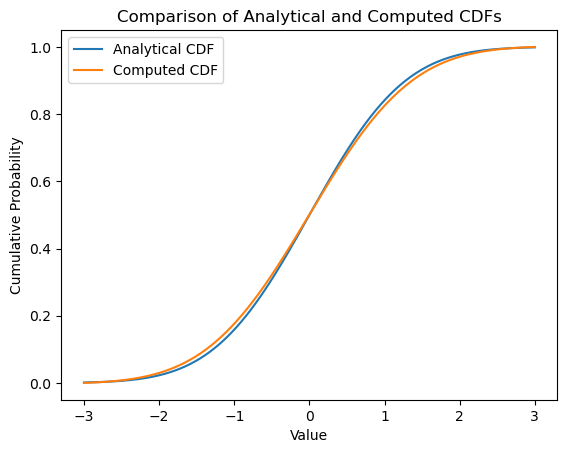

In [12]:
# Analytical CDF for standard normal distribution
analytical_cdf = norm.cdf(grid_densities)

# Plot
plt.plot(grid_densities, analytical_cdf, label="Analytical CDF")
plt.plot(
    grid_densities,
    cs_discretized[14],
    label="Computed CDF",
)  # Adjust index as needed
plt.legend()
plt.xlabel("Value")
plt.ylabel("Cumulative Probability")
plt.title("Comparison of Analytical and Computed CDFs")
plt.show()

## Perform FPCA

In [13]:
# Compute moments to work with in FPCA
mean_function, centered_densities, cov_matrix = compute_moments(ds_discretized)

In [14]:
# Compute the eigenfunctions (principal components) of the covariance matrix
eigenvalues, eigenfunctions = compute_principal_components(cov_matrix, grid_densities)

In [15]:
# Compute FPC scores / factor loadings
fpc_scores = compute_fpc_scores(centered_densities, eigenfunctions, grid_densities)

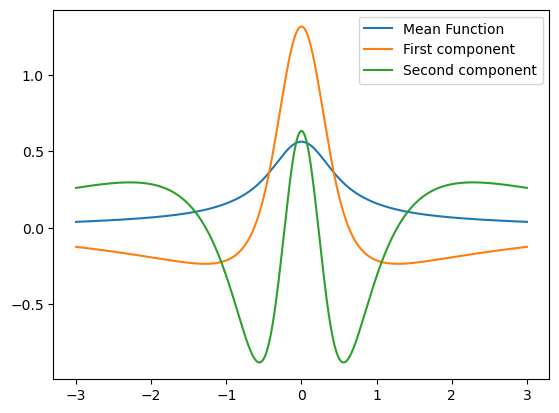

In [16]:
# Plot the mean function and the first two eigenfunctions
fig, ax = plt.subplots()
ax.plot(grid_densities, mean_function, label="Mean Function")
ax.plot(grid_densities, eigenfunctions[:, 0], label="First component")
ax.plot(grid_densities, eigenfunctions[:, 1], label="Second component")
plt.legend()
plt.show()

## More reproducing of Petersen & Müller (2016)

In [17]:
# Compute first two modes of variation
first_two_modes = mode_of_variation(
    mean_function,
    eigenvalues[:2],
    eigenfunctions[:, :2],
    1
)

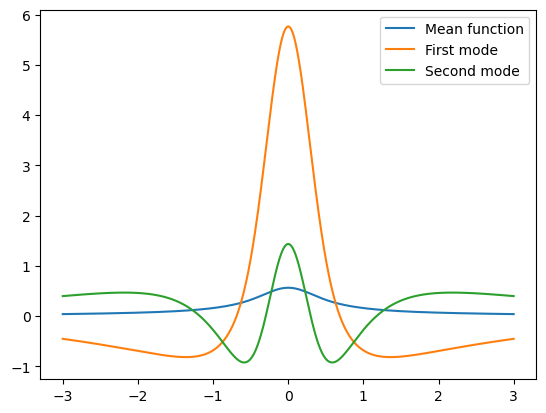

In [18]:
fig, ax = plt.subplots()
ax.plot(grid_densities, mean_function, label="Mean function")
ax.plot(grid_densities, first_two_modes[:, 0], label="First mode")
ax.plot(grid_densities, first_two_modes[:, 1], label="Second mode")
plt.legend()
plt.show()

## Fréchet mean estimation

In [59]:
mean_qdf = np.mean(qds_discretized, axis=0)
mean_qdf *= (
        (grid_densities[-1] - grid_densities[0])
        / riemann_sum_arrays(grid_quantiles, array=mean_qdf, axis=0, cumsum=False)
    )
qd2dens(mean_qdf, grid_quantiles, grid_densities)

(array([ 3.20073496e+01,  3.18628382e+01,  3.17183268e+01,  3.15738154e+01,
         3.14293040e+01,  3.12847926e+01,  3.11402812e+01,  3.09957697e+01,
         3.08512583e+01,  3.07067469e+01,  3.05622355e+01,  3.04177241e+01,
         3.02732127e+01,  3.01287013e+01,  2.99841899e+01,  2.98396784e+01,
         2.96951670e+01,  2.95506556e+01,  2.94061442e+01,  2.92616328e+01,
         2.91171214e+01,  2.89726100e+01,  2.88280985e+01,  2.86835871e+01,
         2.85390757e+01,  2.83945643e+01,  2.82500529e+01,  2.81055415e+01,
         2.79610301e+01,  2.78165187e+01,  2.76720072e+01,  2.75274958e+01,
         2.73829844e+01,  2.72384730e+01,  2.70939616e+01,  2.69494502e+01,
         2.68049388e+01,  2.66604274e+01,  2.65159159e+01,  2.63714045e+01,
         2.62268931e+01,  2.60823817e+01,  2.59378703e+01,  2.57933589e+01,
         2.56488475e+01,  2.55043361e+01,  2.53598246e+01,  2.52153132e+01,
         2.50708018e+01,  2.49262904e+01,  2.47817790e+01,  2.46372676e+01,
         2.4

In [54]:
def qd2dens(qds_discretized, qdsup=None, dsup=None):
    # Validate input

    if not np.allclose([np.min(qdsup), np.max(qdsup)], [0, 1], atol=1e-5):
        print([np.min(qdsup), np.max(qdsup)])
        raise ValueError("Please check the support of the qds_discretized domain's boundaries.")
    
    integral_qd = riemann_sum_arrays(qdsup, array=qds_discretized, axis=0, cumsum=True)
    if not np.isclose(integral_qd[-1], np.ptp(dsup), atol=1e-5):
        print(integral_qd, np.ptp(dsup))
        raise ValueError("Quantile Density should integrate to the range of dsup.")
    
    # Calculate new support grid
    dtemp = dsup[0] + integral_qd
    
    # Calculate density
    dens_temp = 1 / qds_discretized
    dtemp, idx_unique = np.unique(dtemp, return_index=True)
    dens_temp = dens_temp[idx_unique]
    dens_interp = interp1d(dtemp, dens_temp, kind='linear', fill_value="extrapolate")
    dens = dens_interp(dsup)
    
    # Normalize the density
    dens = dens / np.trapz(dens, dsup)
    
    return dens, dtemp

In [55]:
def wasserstein_frechet_mean(qds_discretized, grid, qdsup=None):
    """Compute Wasserstein-Fréchet mean from sample."""
    if qdsup is None:
        qdsup = np.linspace(0, 1, len(qds_discretized))
    mean_qdf = np.mean(qds_discretized, axis=0)
    mean_qdf = (
        mean_qdf
        * (grid[-1] - grid[0])
        / riemann_sum_arrays(qdsup, array=mean_qdf, axis=0, cumsum=False)
    )
    return qd2dens(mean_qdf, qdsup=qdsup, dsup=grid)

In [56]:
def density_from_qd(qds_discretized, dsup, qdsup=None):
    """Compute density from a quantile density function.

    'Inspired' from qd2dens in fdadensity package in R.

    """
    if qdsup is None:
        qdsup = np.linspace(0.2, 1, len(qds_discretized))
    quantile_oplus = start_quantile  + riemann_sum_arrays(
        support_grid=qdsup, array=qds_discretized, axis=0, cumsum=True
    )

    dens_temp = 1 / qds_discretized
    ind = np.unique(quantile_oplus, return_index=True)[1]
    quantile_oplus = np.atleast_1d(quantile_oplus)[ind]
    dens_temp = dens_temp[~ind]
    dens = np.interp(dsup, quantile_oplus, dens_temp)
    dens /= riemann_sum_arrays(dsup, dens, axis=0, cumsum=False)

    return dens, quantile_oplus

In [57]:
f_oplus, quantile_oplus = wasserstein_frechet_mean(
    qds_discretized,
    grid_densities,
    grid_quantiles
)
F_oplus = cdf_from_density(
    grid_densities,
    f_oplus,
    axis=0,
)
F_oplus[-1]

c:\Coding\thesis_frechet_fda\src\frechet_fda\misc.py:140: UserWarning: Not all provided densities integrate to 1!
 Max case of deviation is: 0.09607427120296474 
 In position: 0 
 Performing normalization...
  warnings.warn(


1.0

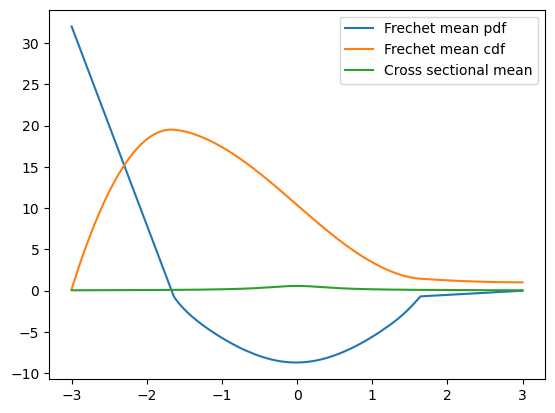

In [58]:
fig, ax = plt.subplots()
ax.plot(grid_densities, f_oplus, label="Frechet mean pdf")
ax.plot(grid_densities, F_oplus, label="Frechet mean cdf")
ax.plot(grid_densities, mean_function, label="Cross sectional mean")
plt.legend()
plt.show()

In [60]:
mean_qdf = np.mean(qds_discretized, axis=0)
mean_qf = np.mean(qs_discretized, axis=0)

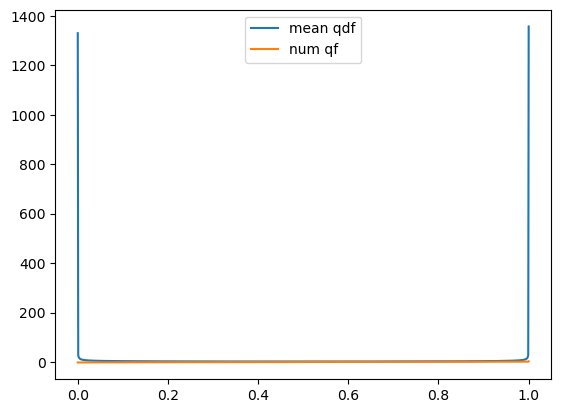

In [61]:
mqdf = mean_qdf #np.mean(tempi, axis=0)
fig, ax = plt.subplots()
ax.plot(grid_quantiles, mqdf, label="mean qdf")
ax.plot(grid_quantiles, grid_densities[0] + riemann_sum_arrays(grid_quantiles, array=mqdf, axis=0, cumsum=True), label="num qf")
# ax.plot(grid_quantiles, mean_qf, label="analytical qf")
plt.legend()
plt.show()

In [26]:
def fve(k):
    """Compute explained variance."""
    return np.sum(eigenvalues[:k]) / np.sum(eigenvalues)


fve(1), fve(2)

(0.8790804571454466, 0.9855911290852554)

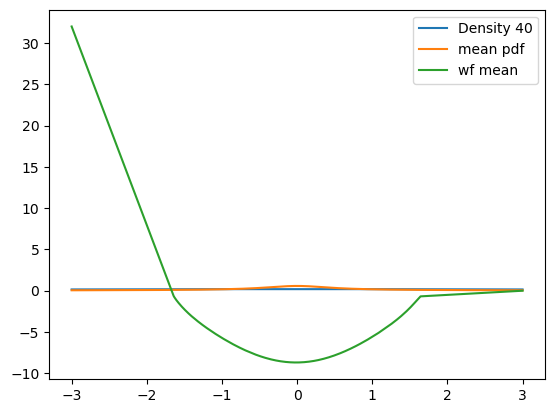

In [64]:
fig, ax = plt.subplots()
# for i in range(3):
#     j = i + 39
#     ax.plot(grid_densities, ds_discretized[j], label=f"Density {j}")
ax.plot(grid_densities, ds_discretized[40], label=f"Density {40}")
ax.plot(grid_densities, mean_function, label="mean pdf")
ax.plot(grid_densities, f_oplus, label="wf mean")
# ax.plot(grid_quantiles, mean_qf[0] + riemann_sum_arrays(grid_quantiles, array=mean_qdf, axis=0, cumsum=True), label="qf")
plt.legend()
plt.show()